In [1]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
sys.path.append('./../../RoboPoint/')

from robopoint_utils import load_model, get_coordinates, generate_prompt, do_inference_with_logits, calculate_probs_per_coordinate
from utils import extract_all, plot_scatter, calculate_euclidian_distance, calculate_normalized_euclidian_distance, visualize_points_on_image, close_all_images

2025-02-04 12:38:07.935829: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-04 12:38:08.008191: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-04 12:38:08.008217: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-04 12:38:08.008240: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-04 12:38:08.504874: I tensorflow/core/platform/cpu_feature_g

In [2]:
model_name = "wentao-yuan/robopoint-v1-vicuna-v1.5-13b"
model, processor, tokenizer = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of the model checkpoint at wentao-yuan/robopoint-v1-vicuna-v1.5-13b were not used when initializing LlavaLlamaForCausalLM: ['model.vision_tower.vision_tower.vision_model.embeddings.class_embedding', 'model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.weight', 'model.vision_tower.vision_tower.vision_model.embeddings.position_embedding.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder

In [3]:
def calculate_spread(points):
    """
    Computes the maximum Euclidean distance between two farthest points in a given list.
    
    :param points: List or numpy array of (x, y) coordinates.
    :return: Maximum Euclidean distance.
    """
    points = np.array(points)
    
    # Compute convex hull
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]

    # Compute pairwise distances only among hull points
    max_dist = 0

    for i in range(len(hull_points)):
        for j in range(i + 1, len(hull_points)):
            max_dist = max(max_dist, distance.euclidean(hull_points[i], hull_points[j]))

    return max_dist

In [4]:
from PIL import Image

def run_scatter_experiment(prompts, temperatures, runs_per_instance, ignoreCoordinateDecimalPlaces, experiment_path = "../data/first_experiments"):
    tasks, images, ground_truths, object_list = extract_all(experiment_path)

    list_of_distances = []
    list_of_probs = []
    labels = []
    for i in range(len(tasks)):
        print(f"Task: {i + 1}")
        print(tasks[i])
    
        image_path = images[i]
        task = tasks[i]
        objects = object_list[i]
        groundtruths = ground_truths[i]
    

        with Image.open(image_path) as image:
            width, height = image.size
            for object, groundtruth in zip(objects, groundtruths):
                distances = []
                probs = []

                for prompt_start in prompts:
                    prompt = generate_prompt(object, prompt_start)

                    for temperature in temperatures:
                    
                        for j in range(runs_per_instance):
                            generated_text, outputs = do_inference_with_logits(image, prompt, model, processor, tokenizer, temperature)
                            #print(f"Output: {generated_text}")
                            
                            coordinates = get_coordinates(generated_text, width, height)
                            if len(coordinates) == 0:
                                continue
                                
                            first_prob = calculate_probs_per_coordinate(outputs, ignoreCoordinateDecimalPlaces)[0].item()
                            distance = calculate_normalized_euclidian_distance(coordinates[0], groundtruth, width, height)
                    
                            #image_coordinate_list.append(coordinates)
                            #image_labels.append(f"Run: {j + 1}")
                    
                            distances.append(distance)
                            probs.append(first_prob)
                        
                            
                        #visualize_points_on_image(image, image_labels, image_coordinate_list, object)
                label = task + " (" + object + ")"
                labels.append(label)
                list_of_distances.append(distances)
                list_of_probs.append(probs)
                
    plot_scatter(labels, list_of_probs, list_of_distances)

Task: 1
pull the oven tray


/home/kit/stud/uutqh/.local/lib/python3.9/site-packages/transformers/generation/utils.py:1493: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


Task: 2
move the fruit from the left stove to the sink
Task: 3
open low fridge
Task: 4
open the drawer
Task: 5
Move the can from the top left of the burner to the bottom left of the burner
Task: 6
Place the pot to the right of the blue fork.
Task: 7
move the pot from the right to the left stove
Task: 8
put potato in pot or pan
Task: 9
take cucumber out of cup
Task: 10
move the banana from the left stove to the sink
Task: 11
pick up the toast and put it to the sink
Task: 12
close the microwave
Task: 13
push the toaster lever
Task: 14
pick up glass cup
Task: 15
take the broccoli and put it between the two right burners
Task: 16
move the pot from the left to the right stove


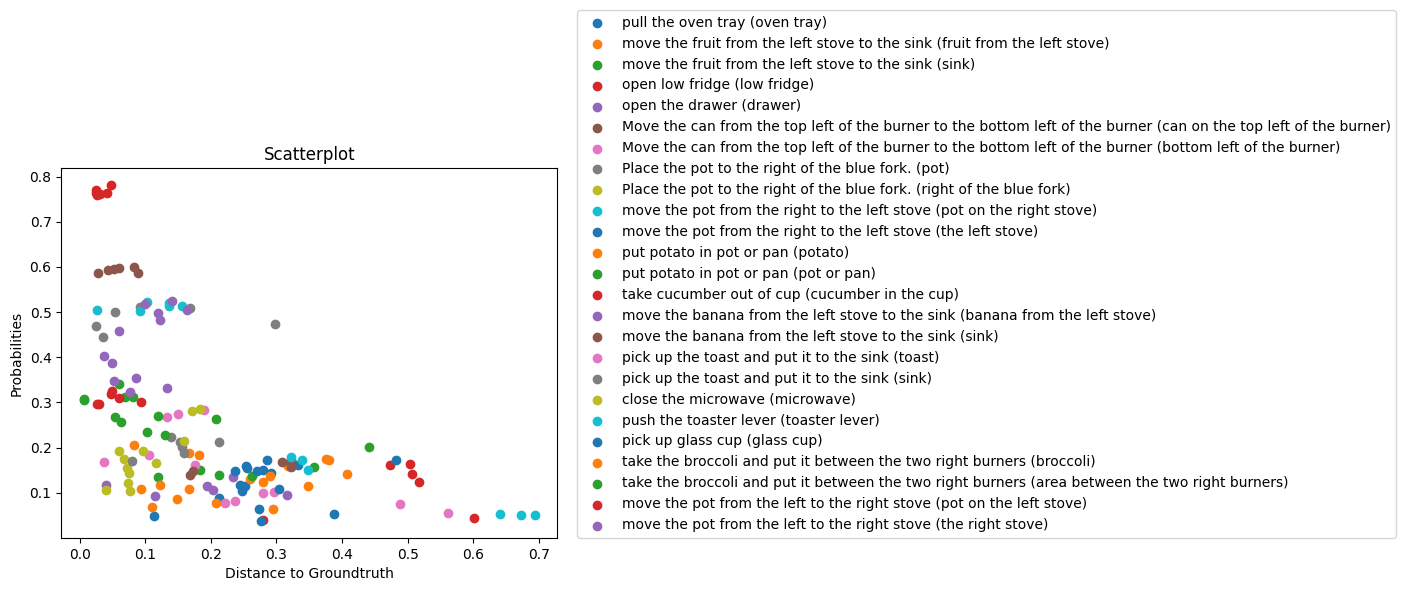

In [5]:
PROMPTS = [
    "Locate several points within the space of the ",
    "Locate several points within the area of the "
]


run_scatter_experiment(
    prompts = PROMPTS,
    temperatures = [0.2, 0.5, 1],
    runs_per_instance = 1,
    ignoreCoordinateDecimalPlaces = True,
    experiment_path = "../data/base_experiments"
)

In [6]:
close_all_images("../data/base_experiments")

Found and closed 26 images.
